# Raw Jet Kinematics

In [1]:
import awkward as ak
import numpy as np
import coffea
import uproot
import hist
import vector
from coffea import util, processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from dask.distributed import Client
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from distributed.diagnostics.plugin import UploadDirectory
from collections import defaultdict
import correctionlib
from coffea.analysis_tools import PackedSelection
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

### Loading the Files

Let's start by opening the ROOT file to be analyzed; we use NanoEventsFactory to construct a TTree with NanoAOD schema out of them. We can view how the NanoAOD files are contructed here **[[1]](https://gitlab.cern.ch/cms-nanoAOD/nanoaod-doc/-/wikis/home)**, with special focus on the NanoAODv9  set from Run2. For example, our dataset wil be located in `samples/flatPU_JMENano_20XX.txt`, and the year range will be 2016, 2016APV, 2017, and 2018. Next, we see that `samples/flatPU_JMENano_20XX.txt` contains many ROOT files with the following format for their respective years:

- **2016 Era** -   `/store/mc/RunIISummer20UL16NanoAODAPVv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/FlatPU0to75_106X_mcRun2_asymptotic_preVFP_v11-v1/120000/0AC69980-C070-954D-A349-3F134CC8E5B8.root`
- **2016APV Era** - `/store/mc/RunIISummer20UL16NanoAODAPVv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/FlatPU0to75_106X_mcRun2_asymptotic_preVFP_v11-v1/120000/0AC69980-C070-954D-A349-3F134CC8E5B8.root`
- **2017 Era** -   `/store/mc/RunIISummer20UL17NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/FlatPU0to75_20UL17JMENano_106X_mc2017_realistic_v9-v1/60000/044B12F6-C47A-A143-9A1D-6FC0A863E6AB.root`
- **2018 Era** -   `/store/mc/RunIISummer20UL18NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/FlatPU0to75_20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/2550000/00C4553F-498A-6C43-8144-3CE0FE0CEC15.root`

To access the files, we add the `root://xcache/` prefix when working on Coffea Casa. Sticking to the 2018 dataset for demonstration purposes, our first task once the TTree object has been created is to access its fields, which are much like keys from python dictionaries. As we can see from `/store/mc`, this is a Monte Carlo dataset and so its contents in their entirety can be found here **[[2]](https://cms-nanoaod-integration.web.cern.ch/autoDoc/NanoAODv9/2016ULpreVFP/doc_TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8_RunIISummer20UL16NanoAODAPVv9-106X_mcRun2_asymptotic_preVFP_v11-v1.html)**. For now, lets view all of its fields/keys:

In [2]:
my_file = 'root://xcache//store/mc/RunIISummer20UL18NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/FlatPU0to75_20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/2550000/00C4553F-498A-6C43-8144-3CE0FE0CEC15.root'
#my_file = 'root://xcache//store/mc/RunIISummer20UL17NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/FlatPU0to75_20UL17JMENano_106X_mc2017_realistic_v9-v1/60000/044B12F6-C47A-A143-9A1D-6FC0A863E6AB.root'
#my_file = 'root://xcache//store/mc/RunIISummer20UL16NanoAODAPVv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/FlatPU0to75_106X_mcRun2_asymptotic_preVFP_v11-v1/120000/0AC69980-C070-954D-A349-3F134CC8E5B8.root'
#my_file = 'root://xcache//store/mc/RunIISummer20UL16NanoAODAPVv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/FlatPU0to75_106X_mcRun2_asymptotic_preVFP_v11-v1/120000/0AC69980-C070-954D-A349-3F134CC8E5B8.root'

my_events = NanoEventsFactory.from_root(my_file, schemaclass=NanoAODSchema).events()
my_events.fields

['LowPtElectron',
 'genWeight',
 'SubJet',
 'btagWeight',
 'fixedGridRhoFastjetCentralNeutral',
 'L1',
 'fixedGridRhoFastjetCentralChargedPileUp',
 'L1Reco',
 'genTtbarId',
 'SV',
 'OtherPV',
 'SoftActivityJetHT5',
 'Tau',
 'GenMET',
 'SoftActivityJetNjets2',
 'fixedGridRhoFastjetCentralCalo',
 'CaloMET',
 'Photon',
 'SoftActivityJetHT2',
 'FsrPhoton',
 'FatJetCHS',
 'PSWeight',
 'RawMET',
 'SoftActivityJetHT10',
 'RawPuppiMET',
 'SoftActivityJetHT',
 'CorrT1METJet',
 'PuppiMET',
 'Muon',
 'DeepMETResponseTune',
 'fixedGridRhoFastjetAll',
 'run',
 'event',
 'Jet',
 'Electron',
 'GenPart',
 'luminosityBlock',
 'SoftActivityJetNjets10',
 'GenJetAK8ForJEC',
 'FatJet',
 'Pileup',
 'boostedTau',
 'L1simulation',
 'HLTriggerFirstPath',
 'HLTriggerFinalPath',
 'Flag',
 'HTXS',
 'SoftActivityJet',
 'JetPuppi',
 'PV',
 'GenIsolatedPhoton',
 'HLT',
 'Generator',
 'JetCalo',
 'fixedGridRhoFastjetCentral',
 'MET',
 'GenDressedLepton',
 'GenVisTau',
 'TrigObj',
 'FatJetForJEC',
 'GenJetAK8',
 'GenV

Since we are interested in jet kinematics, let us focus on the `GenJet`, `Jet`, `GenVTX`, `PV`, `Pileup`, and `fixedGridRhoFastjetAll` fields first. Their definitions are:

- **GenJet** -   slimmedGenJets, i.e. ak4 MC Jets made with visible genparticles; pure MC simulated jets generated by clustering energies of MC particles.
- **Jet** -   slimmedJets, i.e. ak4 PF Jets CHS with JECs applied, after basic selection ($p_T > 15$).
- **GenVTX** -   gen vertex.
- **PV** -   main primary vertex.
- **Pileup** -     the true mean number of the poisson distribution for this event from which the number of interactions each bunch crossing has been sampled.
- **fixedGridRhoFastjetAll** -     rho from all PF Candidates, used e.g. for JECs.

Here `GenJet` and `Jet` will have jet kinematics as sub-fields, which we can immediately put into histograms to analyze their distributions; we will come back to the other four fields shortly. We can also use `events.GenJetAK8` and `events.FatJet` to obtain MC/PF jets clustered with the AK8 rather than AK4 algorithm, though we will focus on AK4 jets. As always, we can use `my_events.Jet?` or `help(my_events.Jet)` for help with documentation with any field.
 
First lets define our jet objects, which will consist of a MC-generated jet, ands a PF reconstructed jet. Later we will refine this and define a reconstructed jet that is within $R = \sqrt{\eta^{2} + \phi^{2}} < 0.2$ in the eta-phi plane of the MC jet using the `nearest` method, which forms part of the `LorentzVector` class in coffea, and its documentation can be found here **[[3]](https://github.com/CoffeaTeam/coffea/blob/ab27195200c46c9b9875e484114ff171b9ea285f/src/coffea/nanoevents/methods/vector.py)**.

In [3]:
gen_jets = my_events.GenJet
reco_jets = my_events.Jet

print(f'GenJet Sub-fields: {gen_jets.fields}\n\nJet Sub-fields: {reco_jets.fields}\n')

GenJet Sub-fields: ['eta', 'mass', 'phi', 'pt', 'nConstituents', 'partonFlavour', 'hadronFlavour']

Jet Sub-fields: ['area', 'btagCSVV2', 'btagDeepB', 'btagDeepCvB', 'btagDeepCvL', 'btagDeepFlavB', 'btagDeepFlavCvB', 'btagDeepFlavCvL', 'btagDeepFlavG', 'btagDeepFlavQG', 'btagDeepFlavUDS', 'chEmEF', 'chFPV0EF', 'chFPV1EF', 'chFPV2EF', 'chFPV3EF', 'chHEF', 'eta', 'hfEmEF', 'hfHEF', 'hfsigmaEtaEta', 'hfsigmaPhiPhi', 'mass', 'muEF', 'muonSubtrFactor', 'neEmEF', 'neHEF', 'particleNetAK4_B', 'particleNetAK4_CvsB', 'particleNetAK4_CvsL', 'particleNetAK4_QvsG', 'particleNetAK4_puIdDisc', 'phi', 'pt', 'puIdDisc', 'puId_beta', 'puId_dR2Mean', 'puId_frac01', 'puId_frac02', 'puId_frac03', 'puId_frac04', 'puId_jetR', 'puId_jetRchg', 'puId_majW', 'puId_minW', 'puId_ptD', 'puId_pull', 'qgl', 'qgl_axis2', 'qgl_ptD', 'rawFactor', 'bRegCorr', 'bRegRes', 'cRegCorr', 'cRegRes', 'electronIdx1', 'electronIdx2', 'hfadjacentEtaStripsSize', 'hfcentralEtaStripSize', 'jetId', 'muonIdx1', 'muonIdx2', 'nConstChHad

Fields of particular interest will be `eta`, `phi`,  and `pt` for both `GenJet` ***and*** `Jet`, as well as `area` and `jetId` for `Jet` ***only***. The definitions of the latter two are:

- **Jet.area** -     jet catchment area, for JECs.
- **Jet.jetId** -     jet ID flags bit1 is loose (always false in 2017 since it does not exist), bit2 is tight, bit3 is tightLepVeto

We will use these attibutes when performing JER corrections and applying event selection masks on our jets. The next step will be to obtain histograms in order to visualize the contents of our file.

### Plotting Raw Jet Kinematics

We begin by defining the eta, phi, and pt kinematics for our MC and reco jets, and print their respective extrema:

In [4]:
print("Gen jets extrema:")
print(f"Eta: {np.min(ak.ravel(gen_jets.eta))}, {np.max(ak.ravel(gen_jets.eta))}")
print(f"Phi {np.min(ak.ravel(gen_jets.phi))}, {np.max(ak.ravel(gen_jets.phi))}")
print(f"Pt: {np.min(ak.ravel(gen_jets.pt))}, {np.max(ak.ravel(gen_jets.pt))}\n")

print("Reco jets extrema:")
print(f"Eta: {np.min(ak.ravel(reco_jets.eta))}, {np.max(ak.ravel(reco_jets.eta))}")
print(f"Phi: {np.min(ak.ravel(reco_jets.phi))}, {np.max(ak.ravel(reco_jets.phi))}")
print(f"Pt: {np.min(ak.ravel(reco_jets.pt))}, {np.max(ak.ravel(reco_jets.pt))}\n")

Gen jets extrema:
Eta: -6.396484375, 6.3916015625
Phi -3.1416015625, 3.1416015625
Pt: 3.0, 6446.01123046875

Reco jets extrema:
Eta: -5.978515625, 5.525390625
Phi: -3.1416015625, 3.1416015625
Pt: 1.4584511518478394e-06, 13464.0



From these values we can see that the ranges of $\eta$ and the azimuthal angle $\phi$ are fairly symmetric, while the $p_T > 0$. Although we are interested in jets with high $p_T$ located in the central region of the CMS detector (i.e. in regions where as $\eta < 2.4$ for example), we explicitly give the entire range in the histograms below. The binnings used correspond to the binnings founds in the JER files such as `Summer19UL18_JRV2_MC_PtResolution_AK4PFchs.txt` which will be used later in the analysis.

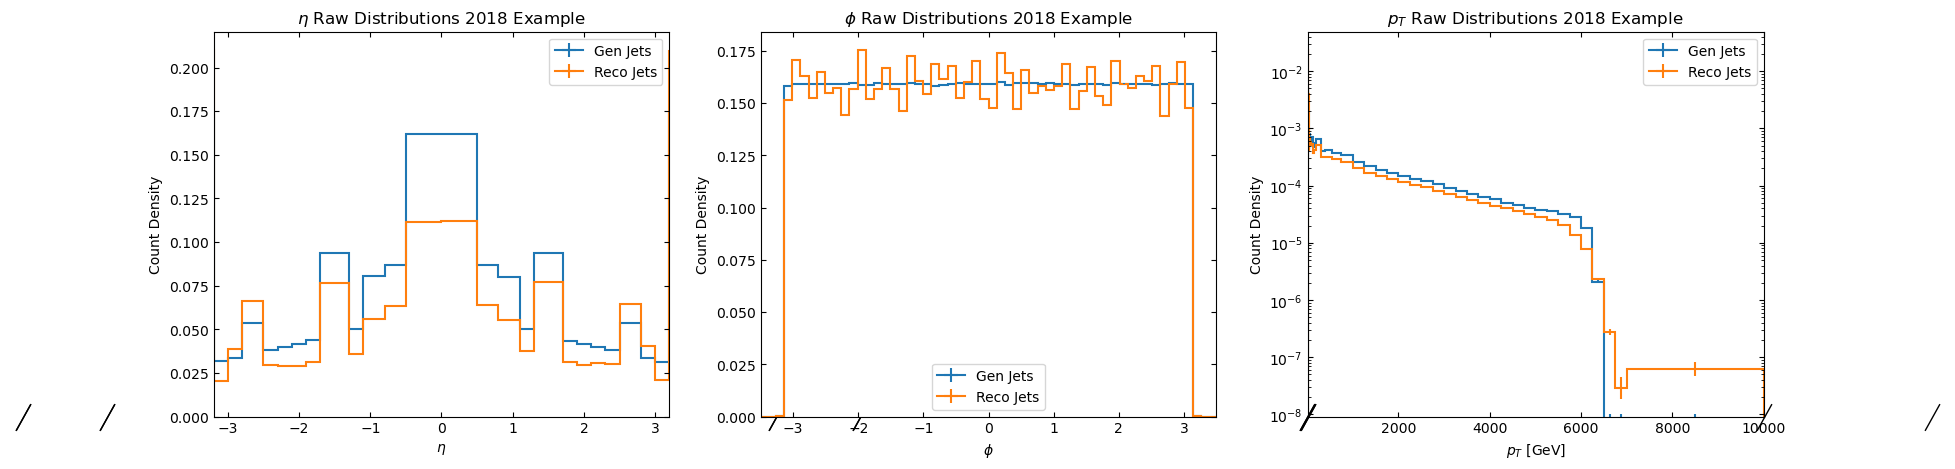

In [5]:
eta_axis = hist.axis.Variable([-4.7, -3.2, -3.0, -2.8, -2.5, -2.3, -2.1, -1.9, -1.7, -1.3, -1.1, -0.8, -0.5, 0, 0.5, 0.8, 1.1, 1.3, 1.7, 1.9, 2.1, 2.3, 2.5, 2.8, 3.0, 3.2, 4.7], name="eta", label="$\eta$") 
phi_axis = hist.axis.Regular(100, -2*np.pi, 2*np.pi, name="phi", label="$\phi$")
pt_axis = hist.axis.Variable(
            [10, 20, 30, 35, 40, 45, 57, 72, 90, 120, 150, 200, 300, 400, 550, 750, 1000, 
            1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000, 4250, 
            4500, 4750, 5000, 5250, 5500, 5750, 6000, 6250, 6500, 6750, 7000, 10000], name="pt", label=r"$p_{T}$ [GeV]"
        )

gen_jets_hist = hist.Hist(eta_axis, phi_axis, pt_axis)
reco_jets_hist = hist.Hist(eta_axis, phi_axis, pt_axis)

#gen_jets = gen_jets[gen_jets.pt > 10]     # For handling error with the logarithm xscale only
#reco_jets = reco_jets[reco_jets.pt > 10]  # For handling error with the logarithm xscale only

gen_jets_hist.fill(eta=ak.ravel(gen_jets.eta), phi=ak.ravel(gen_jets.phi), pt=ak.ravel(gen_jets.pt))
reco_jets_hist.fill(eta=ak.ravel(reco_jets.eta), phi=ak.ravel(reco_jets.phi), pt=ak.ravel(reco_jets.pt))

fig, axs = plt.subplots(1, 3, figsize=(20, 5))

gen_jets_hist.project('eta').plot(ax=axs[0], label="Gen Jets", density=True)
gen_jets_hist.project('phi').plot(ax=axs[1], label="Gen Jets", density=True)
gen_jets_hist.project('pt').plot(ax=axs[2], label="Gen Jets", density=True)

reco_jets_hist.project('eta').plot(ax=axs[0], label="Reco Jets", density=True)
reco_jets_hist.project('phi').plot(ax=axs[1], label="Reco Jets", density=True)
reco_jets_hist.project('pt').plot(ax=axs[2], label="Reco Jets", density=True)

axs[0].set_title("$\eta$ Raw Distributions 2018 Example")
#axs[0].set_yscale('log')
axs[0].set_ylabel('Count Density')
axs[0].set_xlim(-3.2, 3.2)
axs[0].legend()

axs[1].set_title("$\phi$ Raw Distributions 2018 Example")
#axs[1].set_yscale('log')
axs[1].set_ylabel('Count Density')
axs[1].set_xlim(-3.5, 3.5)
axs[1].legend()

axs[2].set_title("$p_T$ Raw Distributions 2018 Example")
#axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_ylabel('Count Density')
axs[2].set_xlim(10, 10000)
axs[2].legend()

for ax in axs:
    ax.tick_params(axis='both', direction='in', which='both', bottom=True, top=True, left=True, right=True)
plt.show()

The three histograms above correspond to the jet distributions projected over pseudorapidity, azimuthal angle, and transverse momentum bins. Each histogram also contains the distributions of MC Generator-level Jets, and PF Reco Jets. The distributions follow the shapes that we expect:

- A symmetric peak in the central $\eta = 0 $ region of the detector, where $p_T$ is the highest. The jet distributions drop with increasing $\eta$ (i.e. towards the endcaps) since here the jets are collinear with the incoming beams, indicating low $p_T$.
- A uniform distributions with respect to the azimuthal angle $\phi$.
- A jet distribution that drops with increasing $p_T$. The number of events per $p_T$ bin remains relatively high for over four orders of magnitude, thus we use a double logarithmic plot.

We can perform the same analysis using numpy, which is shown below since it'll become useful once we have to use `scipy.optimize.curvefit`.

In [6]:
eta_bin_edges = gen_jets_hist.axes.edges[0]
phi_bin_edges = gen_jets_hist.axes.edges[1]
pt_bin_edges = gen_jets_hist.axes.edges[2]

eta_bin_widths = gen_jets_hist.axes.widths[0]
phi_bin_widths = gen_jets_hist.axes.widths[1]
pt_bin_widths = gen_jets_hist.axes.widths[2]

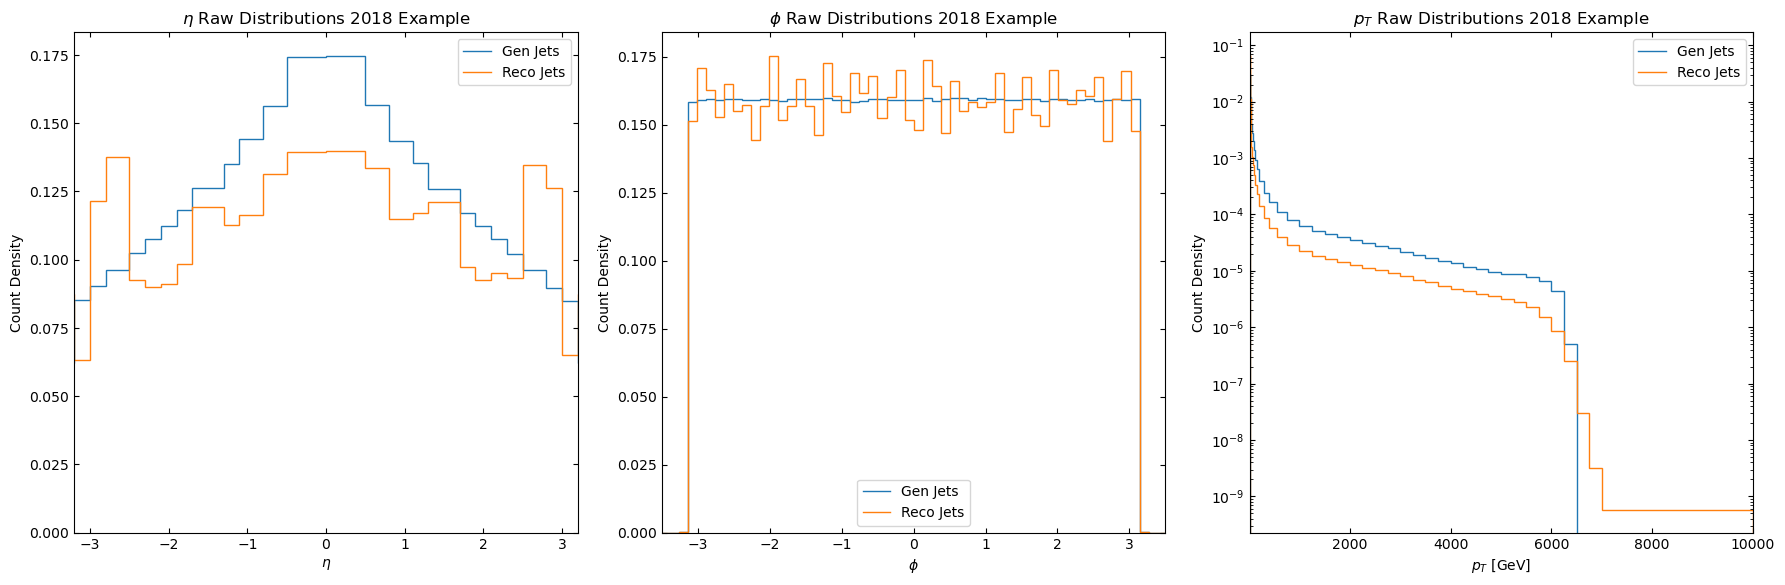

In [7]:
np_gen_jets_hist_eta = gen_jets_hist.project('eta').to_numpy()[0]
np_reco_jets_hist_eta = reco_jets_hist.project('eta').to_numpy()[0]
bin_edges_eta = eta_bin_edges.reshape(-1)
bin_widths_eta = eta_bin_widths.reshape(-1)

np_gen_jets_hist_phi = gen_jets_hist.project('phi').to_numpy()[0]
np_reco_jets_hist_phi = reco_jets_hist.project('phi').to_numpy()[0]
bin_edges_phi = phi_bin_edges.reshape(-1)
bin_widths_phi = phi_bin_widths.reshape(-1)

np_gen_jets_hist_pt = gen_jets_hist.project('pt').to_numpy()[0]
np_reco_jets_hist_pt = reco_jets_hist.project('pt').to_numpy()[0]
bin_edges_pt = pt_bin_edges.reshape(-1)
bin_widths_pt = pt_bin_widths.reshape(-1)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].stairs(np_gen_jets_hist_eta / (np.sum(np_gen_jets_hist_eta) * bin_widths_eta), bin_edges_eta, label="Gen Jets")
axs[0].stairs(np_reco_jets_hist_eta / (np.sum(np_reco_jets_hist_eta) * bin_widths_eta), bin_edges_eta, label="Reco Jets")
axs[0].set_title("$\eta$ Raw Distributions 2018 Example")
axs[0].set_xlabel(r"$\eta$")
axs[0].set_ylabel('Count Density')
#axs[0].set_yscale("log")
axs[0].set_xlim(-3.2, 3.2)
axs[0].legend(frameon=True)

axs[1].stairs(np_gen_jets_hist_phi / (np.sum(np_gen_jets_hist_phi) * bin_widths_phi), bin_edges_phi, label="Gen Jets")
axs[1].stairs(np_reco_jets_hist_phi / (np.sum(np_reco_jets_hist_phi) * bin_widths_phi), bin_edges_phi, label="Reco Jets")
axs[1].set_title("$\phi$ Raw Distributions 2018 Example")
axs[1].set_xlabel(r"$\phi$")
axs[1].set_ylabel('Count Density')
#axs[1].set_yscale("log")
axs[1].set_xlim(-3.5, 3.5)
axs[1].legend(frameon=True)

axs[2].stairs(np_gen_jets_hist_pt / (np.sum(np_gen_jets_hist_pt) * bin_widths_pt), bin_edges_pt, label="Gen Jets")
axs[2].stairs(np_reco_jets_hist_pt/ (np.sum(np_reco_jets_hist_pt) * bin_widths_pt), bin_edges_pt, label="Reco Jets")
axs[2].set_title("$p_T$ Raw Distributions 2018 Example")
axs[2].set_xlabel(r"$p_T$ [GeV]")
axs[2].set_ylabel('Count Density')
#axs[2].set_xscale("log")
axs[2].set_yscale("log")
axs[2].set_xlim(10, 10000)
axs[2].legend(frameon=True)

plt.tight_layout()
for ax in axs:
    ax.tick_params(axis='both', direction='in', which='both', bottom=True, top=True, left=True, right=True)
plt.show()

### Plotting Other Jet Observables

In order to be able to perform calibrations to the Jet Energy Resolution, we need to be able to obtain other jet quantities such as the energy per unit $\eta \times \phi$ area ($\rho$), the number of reconstructed primary vertices ($N_{PV})$, the number of pileup interactions ($N_{PU}$), and the true mean number of PU interactions ($\mu$), as described in these papers **[[4]](https://arxiv.org/abs/1607.03663)**, **[[5]](https://arxiv.org/abs/0707.1378v2)**. As before, we start by examining extrema:

In [8]:
reco_rho = my_events.fixedGridRhoFastjetAll
n_reco_vtx = my_events.PV.npvs
n_pileup = my_events.Pileup.nPU 
pu_nTrueInt = my_events.Pileup.nTrueInt 

print(f"Max rho value: {np.max(reco_rho)}")
print(f"Max number of reconstructed PV: {np.max(n_reco_vtx)}")
print(f"Max number of PU interactions added: {np.max(n_pileup)}")
print(f"Max nTrueInt value: {np.max(reco_rho)}\n")

Max rho value: 88.09797668457031
Max number of reconstructed PV: 157
Max number of PU interactions added: 116
Max nTrueInt value: 88.09797668457031



The pileup parameter $\rho$ is a measure of all the jet energies divided over their corresponding areas in an event, and is therefore an energy density. It forms a background against our measurements, thus we can correct them using $p_{T, i}^{CORR} = p_{T, i}^{RECO} - (\rho \cdot \rm{area_{jet, i}}) \hspace{1mm}$ where the energy density of the event is $\rho = \rm{median}\hspace{1mm}(p_{T,i}^{RECO} / \rm{area_{jet, i}})$. We take the median of the jet energies rather than the average to exclude jets with hight pT, and note that the area of a jet clustered an AK-R algorithm is approximately $\pi R^{2}$.

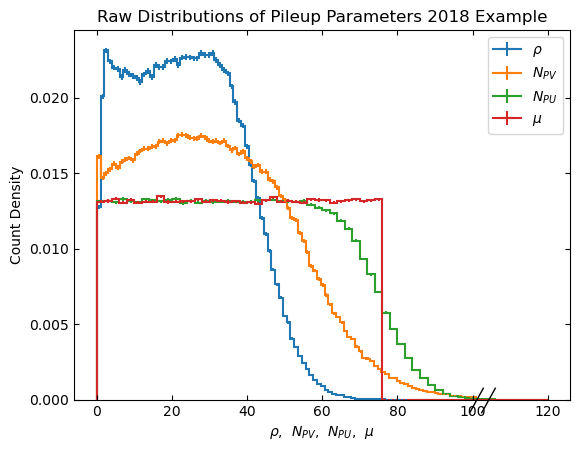

In [9]:
rho_axis = hist.axis.Regular(100, 0, 101, name="rho", label=r"$\rho$") # Used in JER analysis
npvs_axis = hist.axis.Regular(100, 0, 101, name="npvs", label="$N_{PV}$")
npu_axis = hist.axis.Regular(60, 0, 120, name="npu", label="$N_{PU}$") # Used in JER analysis                  
mu_axis = hist.axis.Regular(60, 0, 120, name="mu", label=r"$\mu$")

corrections_histogram = hist.Hist(rho_axis, npvs_axis, npu_axis, mu_axis)
corrections_histogram.fill(rho=ak.ravel(reco_rho), npvs=ak.ravel(n_reco_vtx), npu=ak.ravel(n_pileup), mu=ak.ravel(pu_nTrueInt))

corrections_histogram.project('rho').plot(label=r"$\rho$", density=True)
corrections_histogram.project('npvs').plot(label="$N_{PV}$", density=True)
corrections_histogram.project('npu').plot(label="$N_{PU}$", density=True)
corrections_histogram.project('mu').plot(label=r"$\mu$", density=True)

plt.title("Raw Distributions of Pileup Parameters 2018 Example")
plt.xlabel(r"$\rho$,  $N_{PV}$,  $N_{PU}$,  $\mu$")
plt.ylabel('Count Density')
plt.legend()
plt.gca().tick_params(axis='both', direction='in', which='both', bottom=True, top=True, left=True, right=True)
plt.show()

Ideally number of reconstructed PV equals the number of PU events added, however the vertex finding efficency is not $100\%$ and so we have $N_{PV} \sim 0.70 N_{PU}$ instead.

The last task we want to do is to create a histogram of the jet IDs in our events, which is a criteria used for retaining real jets and rejecting fake jets from noise; they will be useful when applying masks to perform cuts on our jets. Further documentation on jet ID can be found here **[[6]](https://cds.cern.ch/record/1279362/files/JME-10-003-pas.pdfhttps://cds.cern.ch/record/1279362/files/JME-10-003-pas.pdf)**, **[[7]](https://twiki.cern.ch/twiki/bin/viewauth/CMS/JetIDhttps://twiki.cern.ch/twiki/bin/viewauth/CMS/JetID)**. For example, for 2017 and 2018 samples jetId==$2$ means pass Tight ID but fail TightLeptVeto ID, while jetId==$6$ mean pass both. The criteria the jets must pass are given in the table below for AK4CHS jets in different $\eta$ regions: 

|          | $|\eta| \le 2.7$ For AK4CHS and PUPPI Jets _________________________________ |          | $2.7 < |\eta| \le 3.0$ For AK4CHS Jets _____________________________ |     | $|\eta| > 3.0$ For AK4CHS Jets ________________________ |          | 
|:----------------------------:|:------------------:|:------------------:|:------------------:|:------------------:|:------------------:|:------------------:|           
| $\bf{PF Jet ID}$             | $\bf{Tight}$       | $\bf{TightLepVeto}$| $\bf{Tight}$       | $\bf{TightLepVeto}$| $\bf{Tight}$       | $\bf{TightLepVeto}$|
| Neutral Hadron Fraction      | < 0.90             | < 0.90             | -                  | -                  | > 0.02             | -                  |
| Neutral EM Fraction          | < 0.90             | < 0.90             | > 0.02 and < 0.99  | -                  | < 0.90             | -                  |  
| Number of Constitutents      | > 1                | > 1                | -                  | -                  | -                  | -                  |
| Muon Fraction                | -                  | < 0.80             | -                  | -                  | -                  | -                  |
| Number of Neutral Particles  | -                  | -                  | > 2                | -                  | > 10               | -                  |        

Ration of jetId=0 to jetId=6 jets: 0.1474033719913574



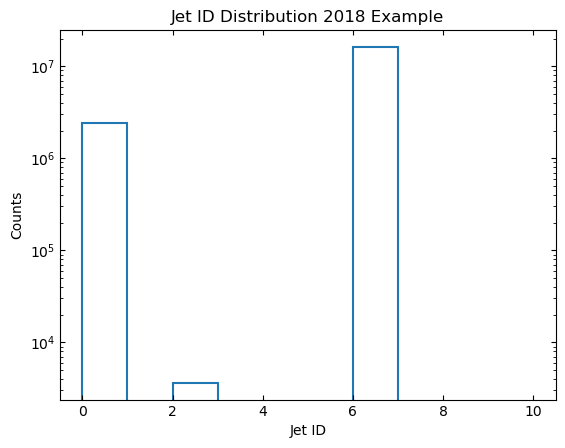

In [10]:
jetIds = reco_jets.jetId

jetIds_ratio = len(ak.ravel(jetIds[jetIds==0])) / len(ak.ravel(jetIds[jetIds==6]))
print(f"Ration of jetId=0 to jetId=6 jets: {jetIds_ratio}\n")

jetIdaxis = hist.axis.Regular(10, 0, 10, name="id", label="Jet ID")

jetId_hist = hist.Hist(jetIdaxis)

jetId_hist.fill(id=ak.ravel(jetIds))

jetId_hist.project('id').plot()

plt.title("Jet ID Distribution 2018 Example")
plt.yscale('log')
plt.ylabel("Counts")
plt.gca().tick_params(axis='both', direction='in', which='both', bottom=True, top=True, left=True, right=True)
plt.show()

We can also show the total number of jets with a particular jet ID, and verify that it matches the total number of jets in our paritcular example:

In [11]:
jetID_list = []

for i in range(10):
    print(f"Number of events with JetId = {i} --------> {len(ak.ravel(jetIds[jetIds==i]))}")
    jetID_list.append(len(ak.ravel(jetIds[jetIds==i])))

#print(jetId_hist.values())
print(f"\nTotal number of jets: {ak.sum(ak.num(reco_jets, axis=1))}")
print(f"Sum of jets from jetID list: {ak.sum(jetID_list)}")

Number of events with JetId = 0 --------> 2398878
Number of events with JetId = 1 --------> 0
Number of events with JetId = 2 --------> 3632
Number of events with JetId = 3 --------> 0
Number of events with JetId = 4 --------> 0
Number of events with JetId = 5 --------> 0
Number of events with JetId = 6 --------> 16274241
Number of events with JetId = 7 --------> 0
Number of events with JetId = 8 --------> 0
Number of events with JetId = 9 --------> 0

Total number of jets: 18676751
Sum of jets from jetID list: 18676751


Lastly, we show 2D histograms of the jet ID vs. $\eta$ to show how fake jets (i.e. jets with jetID = 0) are present throughout the detector, particlarly in its transition regions.

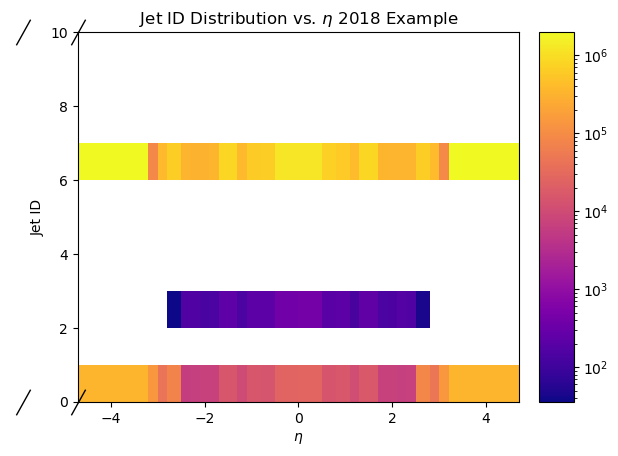

In [12]:
jetIds = reco_jets.jetId

eta_axis = hist.axis.Variable([-4.7, -3.2, -3.0, -2.8, -2.5, -2.3, -2.1, -1.9, -1.7, -1.3, -1.1, -0.8, -0.5, 0, 0.5, 0.8, 1.1, 1.3, 1.7, 1.9, 2.1, 2.3, 2.5, 2.8, 3.0, 3.2, 4.7], name="eta", label="$\eta$") 
jetIdaxis = hist.axis.Regular(10, 0, 10, name="id", label="Jet ID")

jetId_hist = hist.Hist(eta_axis, jetIdaxis)

jetId_hist.fill(eta=ak.ravel(reco_jets.eta), id=ak.ravel(jetIds))

jetId_hist.project('eta', 'id').plot2d(cmap="plasma", norm=LogNorm())

plt.title("Jet ID Distribution vs. $\eta$ 2018 Example")
plt.show()

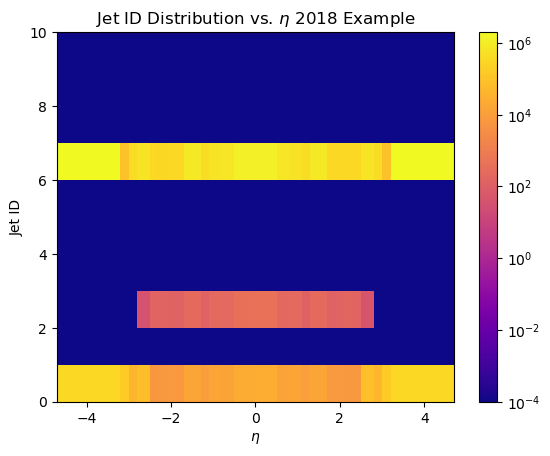

In [13]:
count_number, jetId, eta = jetId_hist.to_numpy()

min_value = 1e-4
count_number = np.maximum(count_number, min_value)

mesh = plt.pcolormesh(jetId, eta, count_number.T, cmap="plasma", norm=LogNorm(vmin=min_value))
plt.colorbar(mesh)
plt.title("Jet ID Distribution vs. $\eta$ 2018 Example")
plt.xlabel(r"$\eta$")
plt.ylabel("Jet ID")
plt.show()